# Goal
Why work on an expired competition you say?

That's actually a good question. 😀

Well the main one would be to be able to access many exceptional resources from the best Kagglers, and learn from them.
We wanted to challenge ourselves with a classification problem where we could practice and improve our skills.
We're going to share on this notebook what we have learned, as it could be useful to future Kagglers, as a summary of the various steps in the Classification workflow.

Here the various steps/sections in case you want to jump around:
<a id='summary'></a>
1. [EDA (Exploratory Data Analysis) & Memory Optimization](#eda)
2. [Preprocessing & Feature Engineering](#fe)
3. [Feature Selection](#fs)
4. [Modeling](#modeling)
5. [Conclusion & Next Steps](#conclusion)

**Keep in mind**: We are going to perform all the steps in this notebook on a subsample of the original data.
This is because we couldn't fit computation on a single Kaggle notebook (30GB RAM).
In our actual code we run code on the full dataset in a sequence of different notebooks.

We tried to use the gargabe collector module, but it doesn't really free up 100% of memory used (you can easily try that by instantiating an object, call del on it and call gc.collect())

### Special Thanks
@Raddar, thank you for your detective work and for sharing it with the community. Seeing the popularity of your dataset, you must have saved thousands of hours of work of Kagglers!

- https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
- https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format

@Thedevastator, this list of tips and tricks is a treasure for anyone approaching Tabular classification (or regression for that matter)

- https://www.kaggle.com/competitions/amex-default-prediction/discussion/335892

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

<a id='eda'></a>
## 1. EDA & Memory Optimization
[Back to summary](#summary)

In this section we'll quickly explore the original raw data and see what we can do to optimize the memory consumption.

With a big dataset such as this one, memory will be our primary constraint.

- [Target column](#target_col)
- [Customer_ID and S_2](#cust_id_col)
- [Categorical columns](#cat_cols)
- [Numerical columns](#num_cols)

<a id='target_col'></a>
### Target
First thing first, let's check the target / label column.

<Axes: xlabel='target', ylabel='count'>

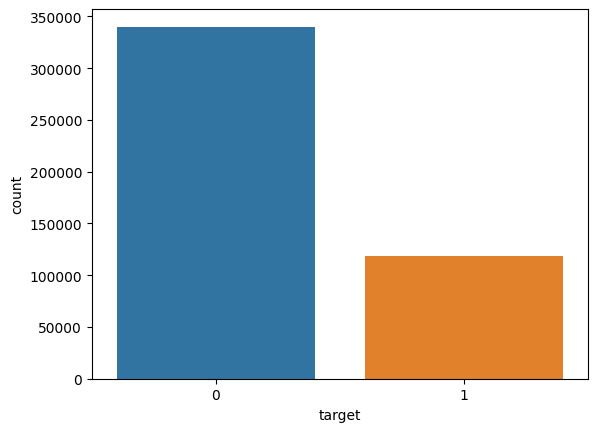

In [2]:
# Let's start by taking a look at labels distribution in training data
labels = pd.read_csv("/kaggle/input/amex-default-prediction/train_labels.csv")
sns.countplot(x=labels["target"])

<a id='cust_id_col'></a>
### Customer_ID and Date
The first 2 columns in the dataset represent the customer id and a date.

Keep in mind that we have data in a monthly granularity, but our predictions will have to be at a customer level, so we will have to aggregate them in some way in a future step.

In [3]:
customer_date_df = pd.read_csv("/kaggle/input/amex-default-prediction/train_data.csv", usecols=[x for x in range(2)])
customer_date_df.head()

,customer_ID,S_2
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16


In [4]:
customer_date_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   customer_ID  object
 1   S_2          object
dtypes: object(2)
memory usage: 991.7 MB


In [5]:
# This show the number of unique values for each column in the dataframe
customer_date_df.nunique()

customer_ID    458913
S_2               396
dtype: int64

In [6]:
# Convert customer_ID to int
unique_ids = customer_date_df['customer_ID'].unique()
id_mapping = {_id: i for i, _id in enumerate(unique_ids)}
customer_date_df['customer_ID'] = customer_date_df['customer_ID'].map(id_mapping).astype(pd.Int32Dtype())
customer_date_df.tail()

,customer_ID,S_2
5531446,458912,2017-11-05
5531447,458912,2017-12-23
5531448,458912,2018-01-06
5531449,458912,2018-02-06
5531450,458912,2018-03-14


In [7]:
# Split the 'date' column into day, month, and year columns
customer_date_df[['year', 'month', 'day']] = customer_date_df['S_2'].str.split('-', expand=True)
customer_date_df = customer_date_df.drop("S_2", axis=1)

In [8]:
# Convert the new columns to integers
customer_date_df["year"] = customer_date_df["year"].astype(pd.Int32Dtype())
customer_date_df["year"] -= 2000
for col in ["year", "month", "day"]:
    customer_date_df[col] = customer_date_df[col].astype(pd.Int8Dtype())

In [9]:
customer_date_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 4 columns):
 #   Column       Dtype
---  ------       -----
 0   customer_ID  Int32
 1   year         Int8 
 2   month        Int8 
 3   day          Int8 
dtypes: Int32(1), Int8(3)
memory usage: 58.0 MB


We reduced the first 2 columns (containing the customer id and the data) from almost 1GB to 58MB. Not bad.

Let's see if they contain any null values.

In [10]:
def plot_null_values(df):
    null_values = df.isnull().mean() * 100
    null_values = null_values.sort_values(ascending=False)
    null_values = null_values[null_values > 0]
    
    if not null_values.empty:
        sns.barplot(y=null_values.index, x=null_values.values)
    else:
        print("No null values")

plot_null_values(customer_date_df)

No null values


No null values in these first 2 columns.

Let's now garbage collect everything and check our memory consumption, before exploring categorical features.

In [11]:
del customer_date_df
del unique_ids
del id_mapping
gc.collect()

32

<a id='cat_cols'></a>
### Categorical columns
We have a list of categorical columns that are given to us directly by AMEX in the competition description.

If we didn't have this information, one way to find out is to call the nunique() function on the full dataset.

Columns with a low value of distinct values compared to the number of rows are usually categories.

In [12]:
categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

# let's just load a couple
cat_df = pd.read_csv("/kaggle/input/amex-default-prediction/train_data.csv", usecols=categorical_columns[:2])
cat_df.head()

,B_30,B_38
0,0.0,2.0
1,0.0,2.0
2,0.0,2.0
3,0.0,2.0
4,0.0,2.0


In [13]:
cat_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   B_30    float64
 1   B_38    float64
dtypes: float64(2)
memory usage: 84.4 MB


In [14]:
# We can map each value of the categorical features to a sequential integer
for col in cat_df.columns:
    unique = cat_df[col].unique()
    mapping = {val: i for i, val in enumerate(unique)}
    cat_df[col] = cat_df[col].map(mapping).astype(pd.Int8Dtype())

In [15]:
cat_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   B_30    Int8 
 1   B_38    Int8 
dtypes: Int8(2)
memory usage: 21.1 MB


Also for categorical features we managed to reduce memory required by 4x!

In [16]:
plot_null_values(cat_df)

No null values


In [17]:
cat_df.nunique()

B_30    4
B_38    8
dtype: int64

<Axes: xlabel='count', ylabel='B_38'>

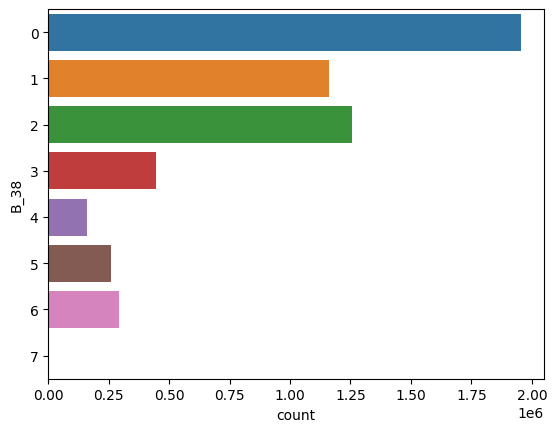

In [18]:
sns.countplot(data=cat_df, y="B_38")

In [19]:
del categorical_columns
del cat_df
del unique
del mapping
gc.collect()

35

<a id='num_cols'></a>
### Numerical columns
The other columns are numerical, and look like continuous features.

But, as @Raddar discovered, many of them are actually discrete features in disguise, and look continuous just because of a random noise of 0-0.01 added.

Like with did for categorical features, we are not going to explore them all.

First, because the process is pretty much the same for each column and it's pretty boring.

Second, because @Raddar already did the heavy-lifting for us, and we can use his dataset in next steps.

In [20]:
# Let's load the customer_ID so that we can join with labels and a single numerical feature
load_cols = ["customer_ID", "D_130"]

num_df = pd.read_csv("/kaggle/input/amex-default-prediction/train_data.csv", usecols=load_cols)
num_df.head()

,customer_ID,D_130
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.002052
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.001034
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.005681
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.007108
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.009680


In [21]:
num_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 2 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_ID  object 
 1   D_130        float64
dtypes: float64(1), object(1)
memory usage: 680.5 MB


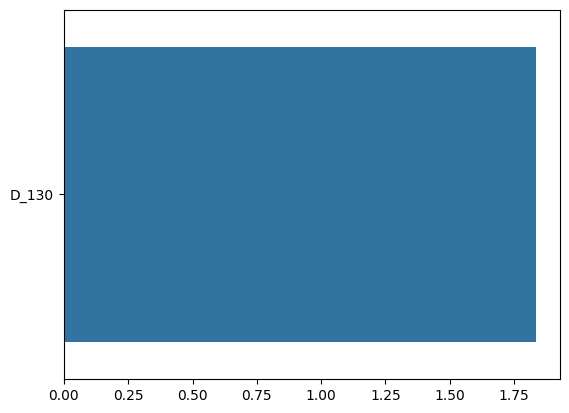

In [22]:
plot_null_values(num_df)

<Axes: xlabel='D_130', ylabel='Count'>

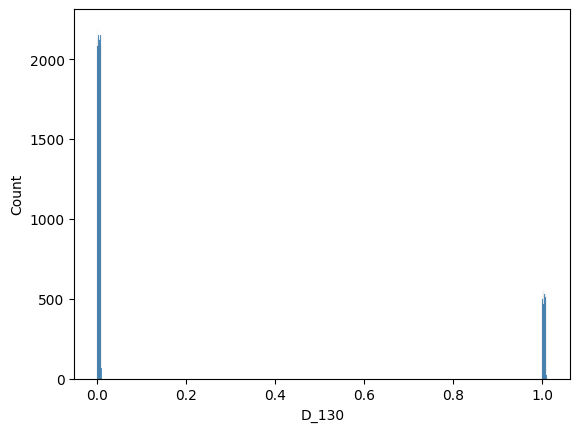

In [23]:
sns.histplot(data=num_df.sample(100000), x="D_130")

<Axes: xlabel='D_130', ylabel='Count'>

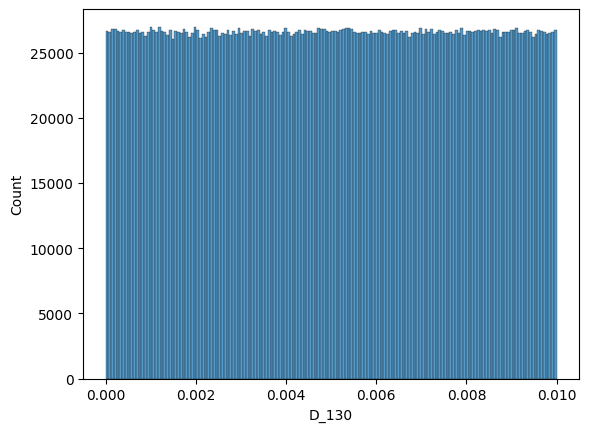

In [24]:
sns.histplot(data=num_df[num_df["D_130"] < 0.1], x="D_130")

<Axes: xlabel='D_130', ylabel='Count'>

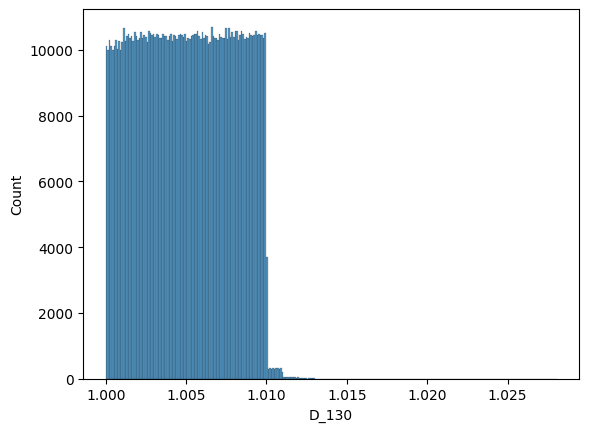

In [25]:
sns.histplot(data=num_df[num_df["D_130"] > 1], x="D_130")

In [26]:
num_df["D_130"] = (np.floor(num_df["D_130"]+1e-6)).fillna(-1)

<Axes: xlabel='D_130', ylabel='Count'>

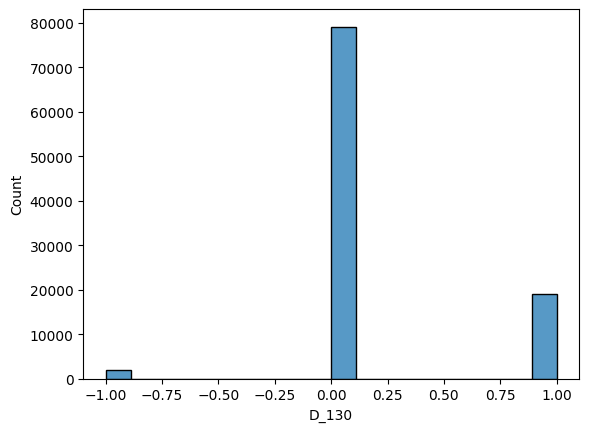

In [27]:
sns.histplot(data=num_df.sample(100000), x="D_130")

In [28]:
num_df["D_130"].value_counts()

D_130
 0.0    4362088
 1.0    1067815
-1.0     101548
Name: count, dtype: int64

In [29]:
merge_df = pd.merge(num_df, labels, on="customer_ID")
merge_df.head()

,customer_ID,D_130,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.0,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.0,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.0,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.0,0


In [30]:
merge_df.shape

(5531451, 3)

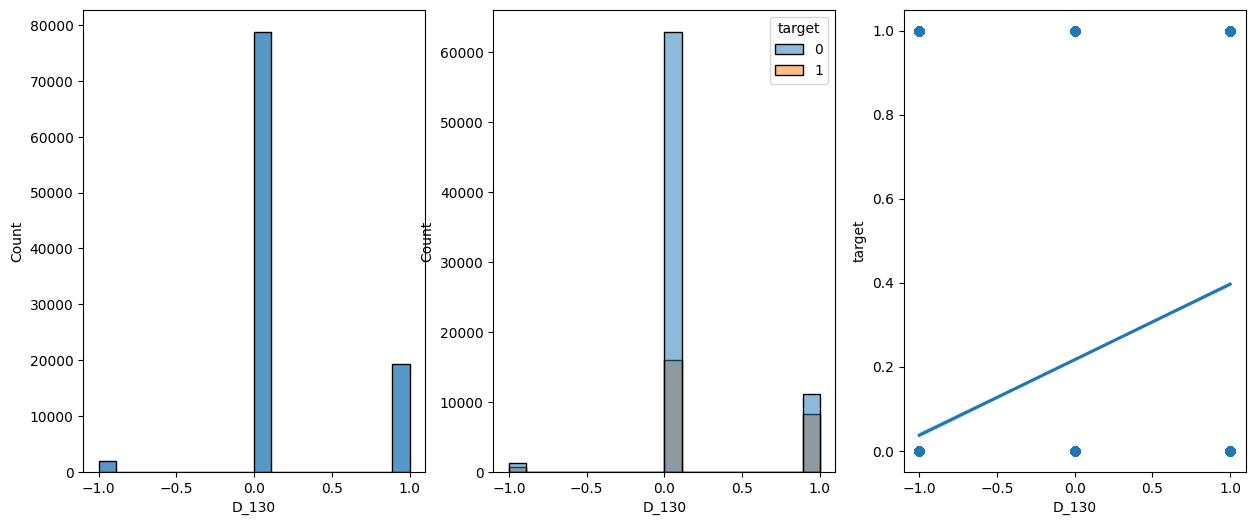

In [31]:
def plot_eda(data, feature, target):
    fig, ax = plt.subplots(1,3, figsize=(15, 6))
    sns.histplot(data=data, x=feature, ax=ax[0])
    sns.histplot(data=data, x=feature, hue=target, ax=ax[1])
    sns.regplot(data=data, x=feature, y=target, ax=ax[2])
    
plot_eda(merge_df.sample(100000), "D_130", "target")

Before going to the next step, let's also see an actual continuous feature.

In [32]:
load_cols = ["customer_ID", "P_2"]

num_df = pd.read_csv("/kaggle/input/amex-default-prediction/train_data.csv", usecols=load_cols)
num_df.head()

,customer_ID,P_2
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.938469
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.936665
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.954180
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.960384
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.947248


In [33]:
merge_df = pd.merge(num_df, labels, on="customer_ID")
merge_df.head()

,customer_ID,P_2,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.938469,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.936665,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.954180,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.960384,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.947248,0


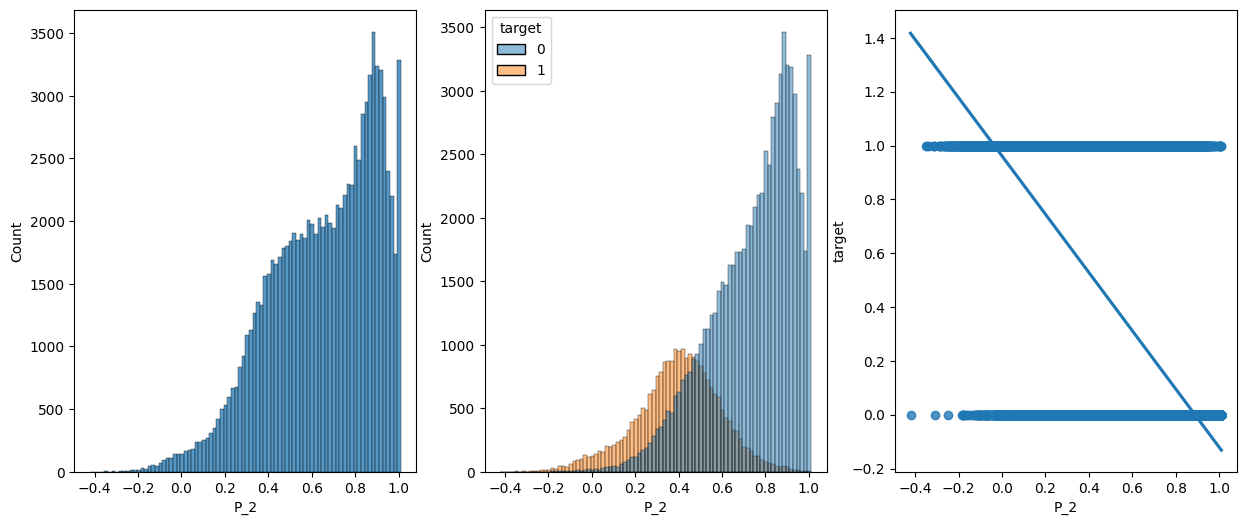

In [34]:
plot_eda(merge_df.sample(100000), "P_2", "target")

In [35]:
del load_cols
del num_df
del merge_df
gc.collect()

577

<a id='fe'></a>
## 2. Preprocessing & Feature Engineering
[Back to summary](#summary)

In this section we are going to perform aggregations and transformation to our data with a dual purpose:

- Aggregate data so that we have a dataset in a customer-level granularity (the same that we are going to base our prediction from)
- Engineer new features that could help us capture different kind of patterns and relationships in the data

Here we are going to start from @Raddar dataset, which is already memory-optimized to take into consideration all the false continuous numeric features we saw in the previous section.

- [Transformations and Aggregations](#transform)
- [Categorical Features](#cat_features)
- [Numerical Features](#num_features)

In [36]:
df_train = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet")
df_train = df_train.set_index("customer_ID")
df_train.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0


In [37]:
df_test = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet")
df_test = df_test.set_index("customer_ID")
df_test.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,2019-02-19,0.631315,0,0.010728,0.814497,0.0,0.168651,0.0,0.002347,0.113189,...,-1,-1,-1,-1,0,NaN,NaN,-1,0.008281,-1
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,2019-03-25,0.587042,0,0.011026,0.810848,0.0,0.241389,0.0,0.009132,0.123035,...,-1,-1,-1,0,0,0.0,NaN,0,0.003753,0
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,2019-04-25,0.609056,0,0.016390,1.004620,0.0,0.266976,0.0,0.004192,0.125319,...,-1,-1,-1,0,0,0.0,NaN,0,0.002156,0
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,2019-05-20,0.614911,0,0.021672,0.816549,0.0,0.188947,0.0,0.015325,0.123438,...,-1,-1,-1,0,0,0.0,NaN,0,0.005206,0
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,2019-06-15,0.591673,8,0.015923,0.810456,0.0,0.180035,0.0,0.011281,0.122212,...,-1,-1,-1,0,0,0.0,NaN,0,0.007421,0


In [38]:
labels = pd.read_csv("/kaggle/input/amex-default-prediction/train_labels.csv", index_col="customer_ID")
labels.head()

,target
customer_ID,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0


In [39]:
df_train = pd.merge(df_train, labels, left_index=True, right_index=True)
df_train.shape

(5531451, 190)

From here on, we are going to work on a subsample of the full data, otherwise we will encounter memory problems in our Kaggle notebook.

In [40]:
class_proportion = df_train["target"].sum() / df_train.shape[0]
class_proportion

0.24909720794778803

In [41]:
# 10k rows subsample
sample_size = 10000

# For our training dataset we are going to maintain the same positive/negative sample ratio!
sample_df_positive = df_train[df_train["target"] == 1].sample(int(sample_size * class_proportion))
sample_df_negative = df_train[df_train["target"] == 0].sample(sample_size - sample_df_positive.shape[0])

# Concat and then shuffle
df_train = pd.concat([sample_df_positive, sample_df_negative])
df_train = df_train.sample(frac=1, random_state=42)

df_train.shape

(10000, 190)

In [42]:
df_test = df_test.sample(10000)
df_test.shape

(10000, 189)

<a id='transform'></a>
### Transform and Aggregate
At the moment we have transactional-level features, but we need to make predictions at customer-level. We need to aggregate features such that they are customer grouped.

We are also going to transform and engineer additional new features by applying various transformations.

We are going to apply only some of the aggregation/transformations listed below, to save memory.

Theoretically we could apply all of those (and more) to engineer even more features and discover other patterns in data.

#### Aggregations
Numerical features:
- sum
- mean
- median
- variance
- std
- first
- last

Categorical features:
- sum (one hot encoding)
- first
- last

#### Transformations
Numerical features:
- log
- square root
- square
- cube

Categorical features:
- one hot encoding

In [43]:
categorical_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
date_col = "S_2"
id_col = "customer_ID"
target_col = "target"
numerical_features = [x for x in df_train.columns if x not in categorical_features and x != date_col and x != id_col and x != target_col]

<a id='cat_features'></a>
### Categorical Features
For the categorical features we are going to apply one hot encoding:
1. get all possible values for each feature (both train and test datasets)
2. (optional) convert all these values to an incremental integer (just to save memory)
3. apply one hot encoding with pandas get_dummies or with scikit-learn OneHotEncoder
4. if the dataset is missing one or more possible values for the feature add additional columns with 0s

It would be much easier to concat the 2 dataframes, apply one hot encoding and then split them again.

But again, memory.

In [44]:
unique_categories = {}
for col in categorical_features:
    unique_categories[col] = set(df_train[col].unique()).union(set(df_test[col].unique()))

# Combine unique categories and create a mapping to integers
category_to_int = {col: {category: i for i, category in enumerate(categories)} for col, categories in unique_categories.items()}
category_to_int

{'B_30': {0: 0, 1: 1, 2: 2, -1: 3},
 'B_38': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, -1: 7},
 'D_114': {0: 0, 1: 1, -1: 2},
 'D_116': {0: 0, 1: 1, -1: 2},
 'D_117': {0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, -1: 7},
 'D_120': {0: 0, 1: 1, -1: 2},
 'D_126': {0: 0, 1: 1, 2: 2, -1: 3},
 'D_63': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5},
 'D_64': {0: 0, 1: 1, 2: 2, 3: 3, -1: 4},
 'D_66': {0: 0, 1: 1, -1: 2},
 'D_68': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, -1: 7}}

In [45]:
def one_hot_encoding(df, categorical_features, category_to_int):
    df[categorical_features] = df[categorical_features].apply(lambda col: col.map(category_to_int[col.name]))
    df = pd.get_dummies(df, columns=categorical_features)
    
    ohe_cols = []
    
    for col in categorical_features:
        for k,v in category_to_int[col].items():
            ohe_cols.append(f"{col}_{v}")
            if f"{col}_{v}" not in df.columns:
                df[f"{col}_{v}"] = 0
    
    return df, ohe_cols

df_train, _ = one_hot_encoding(df_train, categorical_features, category_to_int)
df_test, ohe_cols = one_hot_encoding(df_test, categorical_features, category_to_int)

In [46]:
df_train.shape

(10000, 234)

In [47]:
df_test.shape

(10000, 233)

After applying one hot encoding on our datasets, the number of columns goes from 189 to 233 (+target for df_train).

Now we can aggregate these new one hot encoded columns at a customer level. We are going to sum the values.

In [48]:
aggregated_cat_df_train = df_train.groupby('customer_ID')[ohe_cols].agg(['sum'])
aggregated_cat_df_train.columns = aggregated_cat_df_train.columns.map('_'.join)
aggregated_cat_df_train = aggregated_cat_df_train.reset_index()
aggregated_cat_df_train.head()

,customer_ID,B_30_0_sum,B_30_1_sum,B_30_2_sum,B_30_3_sum,B_38_0_sum,B_38_1_sum,B_38_2_sum,B_38_3_sum,B_38_4_sum,...,D_66_1_sum,D_66_2_sum,D_68_0_sum,D_68_1_sum,D_68_2_sum,D_68_3_sum,D_68_4_sum,D_68_5_sum,D_68_6_sum,D_68_7_sum
0,0003e58375faf90552b2861c1ccea4ee5757827cbb6ecd...,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,000f6da00ca504da14c0079936e8dc9f4971fc4405e45d...,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,001622b52f6cf47344ffc23ab4e468fc33104a52147a41...,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,001626099060b23a2fccf651dcf67b1f22aba9f2443337...,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0019d00f6dcd584a6829b7b971e2f3394b9f2bcccea734...,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [49]:
aggregated_cat_df_test = df_test.groupby('customer_ID')[ohe_cols].agg(['sum'])
aggregated_cat_df_test.columns = aggregated_cat_df_test.columns.map('_'.join)
aggregated_cat_df_test = aggregated_cat_df_test.reset_index()
aggregated_cat_df_test.head()

,customer_ID,B_30_0_sum,B_30_1_sum,B_30_2_sum,B_30_3_sum,B_38_0_sum,B_38_1_sum,B_38_2_sum,B_38_3_sum,B_38_4_sum,...,D_66_1_sum,D_66_2_sum,D_68_0_sum,D_68_1_sum,D_68_2_sum,D_68_3_sum,D_68_4_sum,D_68_5_sum,D_68_6_sum,D_68_7_sum
0,00041d031f2b2c9facd1dda2adb2ddd5bd1f95143a2208...,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0004fbbc37e3147810d2d8a8d26b5a18dfb3755dba74c1...,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,00059a7fc495b3bc71df7c4d90800d8ee83377ef8fe4ad...,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
3,000b2852a854925d519fed1a6af358e55e9fd7b3e09f79...,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0011edcc2435b5382ecb9c1b320a65ac84478dccacf29d...,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


<a id='num_features'></a>
### Numerical features

Let's also aggregate numerical_features (on sum and mean)

In [50]:
aggregated_num_df_train = df_train.groupby('customer_ID')[numerical_features].agg(['sum', 'mean'])
aggregated_num_df_train.columns = aggregated_num_df_train.columns.map('_'.join)
aggregated_num_df_train = aggregated_num_df_train.reset_index()
aggregated_num_df_train.head()

,customer_ID,P_2_sum,P_2_mean,D_39_sum,D_39_mean,B_1_sum,B_1_mean,B_2_sum,B_2_mean,R_1_sum,...,D_141_sum,D_141_mean,D_142_sum,D_142_mean,D_143_sum,D_143_mean,D_144_sum,D_144_mean,D_145_sum,D_145_mean
0,0003e58375faf90552b2861c1ccea4ee5757827cbb6ecd...,0.833162,0.833162,0,0.0,0.009438,0.009438,0.811348,0.811348,0.003456,...,0.0,0.0,0.0,NaN,0,0.0,0.002465,0.002465,0,0.0
1,000f6da00ca504da14c0079936e8dc9f4971fc4405e45d...,0.680761,0.680761,0,0.0,0.003844,0.003844,0.814641,0.814641,0.009421,...,0.0,0.0,0.0,NaN,0,0.0,0.007598,0.007598,0,0.0
2,001622b52f6cf47344ffc23ab4e468fc33104a52147a41...,0.861326,0.861326,0,0.0,0.008613,0.008613,0.819883,0.819883,0.003111,...,0.0,0.0,0.0,NaN,0,0.0,0.003210,0.003210,0,0.0
3,001626099060b23a2fccf651dcf67b1f22aba9f2443337...,0.917653,0.917653,0,0.0,0.001702,0.001702,0.812355,0.812355,0.008654,...,0.0,0.0,0.0,NaN,0,0.0,0.003892,0.003892,0,0.0
4,0019d00f6dcd584a6829b7b971e2f3394b9f2bcccea734...,0.649067,0.649067,8,8.0,0.038897,0.038897,1.001515,1.001515,0.008600,...,0.0,0.0,0.0,NaN,0,0.0,0.008046,0.008046,0,0.0


In [51]:
aggregated_num_df_test = df_test.groupby('customer_ID')[numerical_features].agg(['sum', 'mean'])
aggregated_num_df_test.columns = aggregated_num_df_test.columns.map('_'.join)
aggregated_num_df_test = aggregated_num_df_test.reset_index()
aggregated_num_df_test.head()

,customer_ID,P_2_sum,P_2_mean,D_39_sum,D_39_mean,B_1_sum,B_1_mean,B_2_sum,B_2_mean,R_1_sum,...,D_141_sum,D_141_mean,D_142_sum,D_142_mean,D_143_sum,D_143_mean,D_144_sum,D_144_mean,D_145_sum,D_145_mean
0,00041d031f2b2c9facd1dda2adb2ddd5bd1f95143a2208...,0.614333,0.614333,22,22.0,0.055190,0.055190,0.423790,0.423790,0.501586,...,0.0,0.0,0.0,NaN,0,0.0,0.006116,0.006116,0,0.0
1,0004fbbc37e3147810d2d8a8d26b5a18dfb3755dba74c1...,1.003460,1.003460,0,0.0,0.003870,0.003870,0.813033,0.813033,0.000000,...,0.0,0.0,0.0,NaN,0,0.0,0.009977,0.009977,0,0.0
2,00059a7fc495b3bc71df7c4d90800d8ee83377ef8fe4ad...,0.174849,0.174849,0,0.0,0.304620,0.304620,0.110822,0.110822,1.000000,...,0.0,0.0,0.0,NaN,0,0.0,0.000107,0.000107,0,0.0
3,000b2852a854925d519fed1a6af358e55e9fd7b3e09f79...,0.889164,0.889164,8,8.0,0.026691,0.026691,0.817224,0.817224,0.000000,...,0.0,0.0,0.0,NaN,0,0.0,0.007419,0.007419,0,0.0
4,0011edcc2435b5382ecb9c1b320a65ac84478dccacf29d...,0.816061,0.816061,0,0.0,0.001812,0.001812,0.811065,0.811065,0.000000,...,0.0,0.0,0.0,NaN,0,0.0,0.003393,0.003393,0,0.0


For each of the numerical features, now we get 2 (one for sum, one for mean).

We're also going to apply different transformations to each of the 2 columns (log and square).

In [52]:
agg_numerical_features = []
for f in numerical_features:
    for a in ['sum', 'mean']:
        agg_numerical_features.append(f"{f}_{a}")

def feature_transformation(df):
        
    # Feature transformation
    new_columns = []

    import warnings

    for feature in agg_numerical_features:

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            log_feature = np.log1p(df[feature])
            square_feature = df[feature] ** 2

        log_feature.name = f'{feature}_log'
        square_feature.name = f'{feature}_square'

        # Append the series to the list
        new_columns.extend([log_feature, square_feature])
    
    df = pd.concat([df, *new_columns], axis=1)
    return df

transformed_num_df_train = feature_transformation(aggregated_num_df_train)
transformed_num_df_train.shape

(9894, 1063)

In [53]:
transformed_num_df_test = feature_transformation(aggregated_num_df_test)
transformed_num_df_test.shape

(9967, 1063)

The number of rows is less than 10k because we grouped by customer.

In the original dataset there are about 13 rows per customer, but here we'll probably experience a lower reduction compared to 13:1 because of the sampled nature of our dataframes.

Let's now merge the aggregated categorical df and aggregated numerical df.

In [54]:
df_train = pd.merge(aggregated_cat_df_train, transformed_num_df_train, left_on="customer_ID", right_on="customer_ID")
df_train = df_train.set_index("customer_ID")
df_train.shape

(9894, 1117)

In [55]:
df_test = pd.merge(aggregated_cat_df_test, transformed_num_df_test, left_on="customer_ID", right_on="customer_ID")
df_test = df_test.set_index("customer_ID")
df_test.shape

(9967, 1117)

In [56]:
del labels
del class_proportion
del numerical_features
del target_col
del id_col
del date_col
del categorical_features
del sample_size
del sample_df_positive
del sample_df_negative
del unique_categories
del category_to_int
del ohe_cols
del aggregated_cat_df_train
del aggregated_cat_df_test
del aggregated_num_df_train
del aggregated_num_df_test
del agg_numerical_features
del transformed_num_df_train
del transformed_num_df_test
gc.collect()

39214

<a id='fs'></a>
## 3. Feature Selection
[Back to summary](#summary)

In this section we are going to select the most informative features out of the 1117 we have.

We are going to perform this in 2 steps:
1. Apply [RFE (recursive feature elimination)](#rfe) to recursively eliminate the least informative features until we reach a desidered number. In this case we are going to aim at 225 (20% of the total)
2. Apply [PCA (principal component analysis)](#pca) to further reduce the dimensionality of our dataset.

In [57]:
labels = pd.read_csv("/kaggle/input/amex-default-prediction/train_labels.csv", index_col="customer_ID")
df_train = pd.merge(df_train, labels, left_index=True, right_index=True)
df_train = df_train.fillna(-1)
df_train = df_train.replace([np.inf, -np.inf], -1)
df_train.head()

,B_30_0_sum,B_30_1_sum,B_30_2_sum,B_30_3_sum,B_38_0_sum,B_38_1_sum,B_38_2_sum,B_38_3_sum,B_38_4_sum,B_38_5_sum,...,D_143_mean_square,D_144_sum_log,D_144_sum_square,D_144_mean_log,D_144_mean_square,D_145_sum_log,D_145_sum_square,D_145_mean_log,D_145_mean_square,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0003e58375faf90552b2861c1ccea4ee5757827cbb6ecd15a334e47e95774185,1,0,0,0,0,1,0,0,0,0,...,0.0,0.002462,0.000006,0.002462,0.000006,0.0,0,0.0,0.0,0
000f6da00ca504da14c0079936e8dc9f4971fc4405e45db424848a3015dde525,1,0,0,0,1,0,0,0,0,0,...,0.0,0.007570,0.000058,0.007570,0.000058,0.0,0,0.0,0.0,0
001622b52f6cf47344ffc23ab4e468fc33104a52147a419e18c855a027035d44,1,0,0,0,0,0,0,0,0,1,...,0.0,0.003205,0.000010,0.003205,0.000010,0.0,0,0.0,0.0,0
001626099060b23a2fccf651dcf67b1f22aba9f24433377e94bbad4daa64296a,1,0,0,0,1,0,0,0,0,0,...,0.0,0.003884,0.000015,0.003884,0.000015,0.0,0,0.0,0.0,0
0019d00f6dcd584a6829b7b971e2f3394b9f2bcccea73457e5104bc52c3ce1cf,1,0,0,0,0,1,0,0,0,0,...,0.0,0.008014,0.000065,0.008014,0.000065,0.0,0,0.0,0.0,0


<a id='rfe'></a>
### RFE

Recursive feature elimination is gonna fit an estimator on the data, and rank the feature importance.

It will then drop the n (step) features with the least importance, and fit the estimator again and so on.

Until it reaches the desired number of features to keep (n_features_to_select)

In [58]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

target_column = 'target'
features = [col for col in df_train.columns if col != target_column]

# We want to standardize features before passing them to the model
scaler = StandardScaler()

# RFE will use RandomForestClassifier as a base model to determine features importance
rfe = RFE(estimator=RandomForestClassifier(), 
          n_features_to_select=225, # number of features we want to keep
          step=50) # how many features to remove at each step

rfe.fit(scaler.fit_transform(df_train[features]), 
        df_train[target_column])

# Get the selected features
selected_features = list(np.array(features)[rfe.support_])

# Print the selected features
print(f"Selected Features: {len(selected_features)}")
print(selected_features)

Selected Features: 225
['P_2_sum', 'P_2_mean', 'B_1_sum', 'B_1_mean', 'B_2_sum', 'B_2_mean', 'R_1_sum', 'R_1_mean', 'S_3_sum', 'S_3_mean', 'B_3_sum', 'B_3_mean', 'D_42_sum', 'D_42_mean', 'D_43_sum', 'D_43_mean', 'D_44_sum', 'B_4_mean', 'D_45_sum', 'D_45_mean', 'B_5_sum', 'B_5_mean', 'D_46_sum', 'D_46_mean', 'D_47_sum', 'D_47_mean', 'D_48_sum', 'D_48_mean', 'B_6_mean', 'B_7_sum', 'B_9_sum', 'B_9_mean', 'D_52_sum', 'D_52_mean', 'P_3_sum', 'P_3_mean', 'B_10_sum', 'B_10_mean', 'S_5_mean', 'B_11_sum', 'B_11_mean', 'S_7_sum', 'S_7_mean', 'B_12_sum', 'B_12_mean', 'D_58_sum', 'D_58_mean', 'D_61_sum', 'D_61_mean', 'D_62_sum', 'D_62_mean', 'B_18_sum', 'S_12_mean', 'R_6_sum', 'R_6_mean', 'B_21_sum', 'B_21_mean', 'D_69_sum', 'D_71_sum', 'B_23_mean', 'B_24_sum', 'B_26_sum', 'B_26_mean', 'S_16_sum', 'B_27_sum', 'B_27_mean', 'S_17_sum', 'S_17_mean', 'S_22_mean', 'S_23_sum', 'S_23_mean', 'S_24_sum', 'S_25_sum', 'S_25_mean', 'S_26_mean', 'D_102_sum', 'D_102_mean', 'B_37_sum', 'R_27_mean', 'B_40_sum', '

In [59]:
df_train = df_train[selected_features]
df_test = df_test[selected_features]
df_train.shape

(9894, 225)

<a id='pca'></a>
### PCA

Principal component analysis is another technique to reduce the number of features.

Also in this case we can select the number of features to keep.

To choose this number we can fit PCA without specifying the number of components and plot the cumulative explained variance.

In this case we are going to keep a dimensionality that maintains (explains) 99% of the dataset variance.

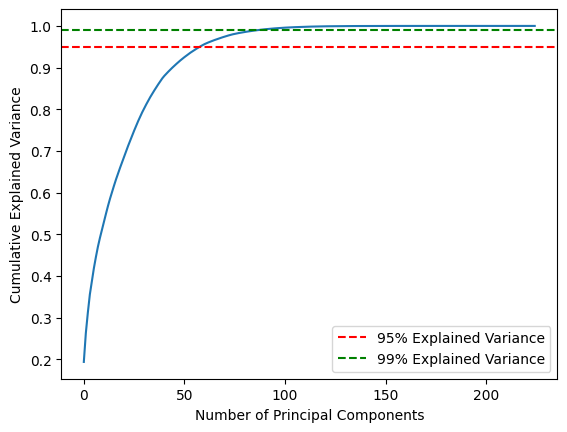

In [60]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())  # PCA without specifying n_components
])

pipeline.fit(df_train)

# Plot cumulative explained variance
pca = pipeline.named_steps['pca']
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Explained Variance')
plt.legend()
plt.show()

In [61]:
# Select the desired number of components based on your analysis
desired_num_components = 100

# Fit PCA with the desired number of components
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=desired_num_components))
])

# Fit the pipeline on the training data
pipeline.fit(df_train)

train_pca = pipeline.transform(df_train)
df_train = pd.DataFrame(train_pca, columns=[f'PC{i+1}' for i in range(desired_num_components)], index=df_train.index)

df_test = df_test.fillna(-1)
df_test = df_test.replace([np.inf, -np.inf], -1)
test_pca = pipeline.transform(df_test)
df_test = pd.DataFrame(test_pca, columns=[f'PC{i+1}' for i in range(desired_num_components)], index=df_test.index)

In [62]:
df_train.shape

(9894, 100)

In [63]:
df_test.shape

(9967, 100)

In [64]:
del scaler
del rfe
del selected_features
del pipeline
del pca
del explained_variance_ratio
del cumulative_explained_variance
del desired_num_components
del train_pca
del test_pca
del target_column
del features
gc.collect()

4008

<a id='modeling'></a>
## 4. Modeling
[Back to summary](#summary)

In this section we are going to build our prediction models.

The plan is to combine boosting and stacking ensemble strategies.

1. First we are going to train 3 "weak" learners that employ gradient boosting (Light GBM, Catboost, XGBoost)
2. We will use these "weak" learners to predict and build a dataframe with these 3 predictions as features
3. Then we are going to train 2 "strong" learners that will be trained on the predictions of the previous 3. For this step we plan to train both a RandomForestClassifier and a LogisticRegression models.
4. The final prediction will be the average of the predictions of the 2 "strong" learners.

- [Baseline performance](#baseline)
- [Weak Learners - Training](#weak_train)
- [Weak Learners - Prediction](#weak_pred)
- [Strong Learners - Training](#strong_train)
- [Strong Learners - Prediction](#strong_pred)

<a id='baseline'></a>
### Baseline
To have a baseline against which to compare our model, let's just get the scores of a RandomForestClassifier on our data.

For the score we will use the same score used by AMEX in the competition, which is the average of normalized weighted gini and the default rate captured at 4%.

You can find the original scoring code on this notebook provided by AMEX:

https://www.kaggle.com/code/inversion/amex-competition-metric-python

In [65]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [66]:
# Here's a method we will use to plot the ROC curve.

def plot_roc_auc(df):

    from sklearn.metrics import roc_curve, auc

    # Extract predicted probabilities and true labels
    pred_prob = df['prediction'].values
    true_labels = df['target'].values

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axvline(x=0.04, color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [67]:
# Method to perform CV

from sklearn.model_selection import StratifiedKFold

def cv_amex_scores(df, model, features, target_column):
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    X = df[features]
    y = df[target_column]

    i = 0
    
    # Perform k-fold cross-validation
    for train_idx, test_idx in kf.split(X, y):
        
        print(f"Run {i+1}-fold CV...")

        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]

        # Train the model
        model.fit(X_train, y_train)

        # Predict probabilities for the test set
        y_prob = model.predict_proba(X_test)[:, 1]
        pred_df = pd.DataFrame(y_prob, columns=['prediction'], index=y_test.index)
        true_df = pd.DataFrame(y_test, columns=['target'])

        result_df = pd.merge(pred_df, true_df, left_index=True, right_index=True)
        plot_roc_auc(result_df)
        
        model_score = amex_metric(true_df, pred_df)
        scores.append(model_score)
        
        print(f"Completed {i+1}-fold CV. Score = {model_score}")
        i += 1

    return scores

Run 1-fold CV...


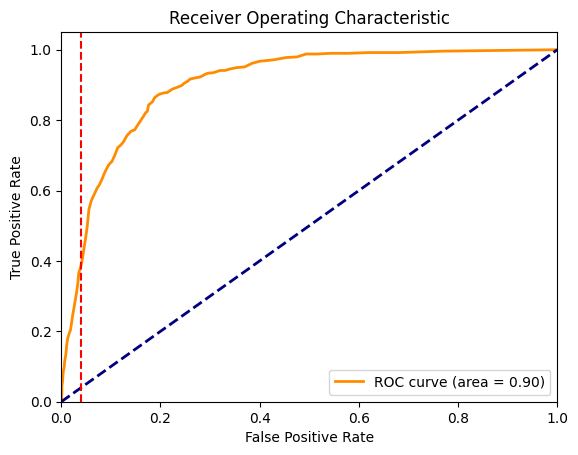

Completed 1-fold CV. Score = 0.5792151459868748
Run 2-fold CV...


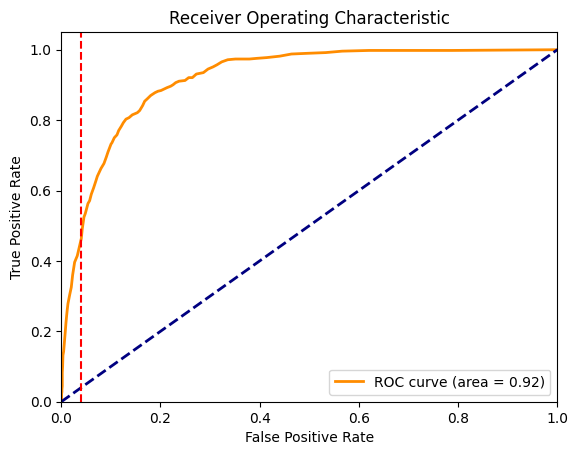

Completed 2-fold CV. Score = 0.6304227982573946
Run 3-fold CV...


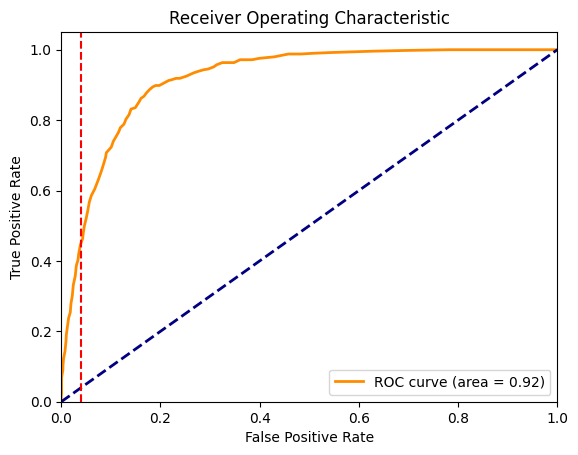

Completed 3-fold CV. Score = 0.6212696181977697
Run 4-fold CV...


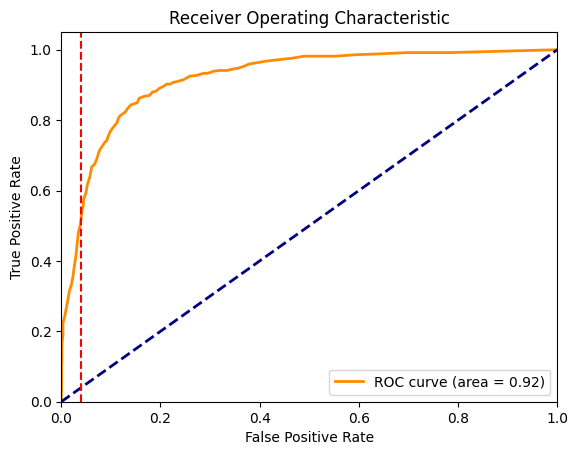

Completed 4-fold CV. Score = 0.6513238113103341
Run 5-fold CV...


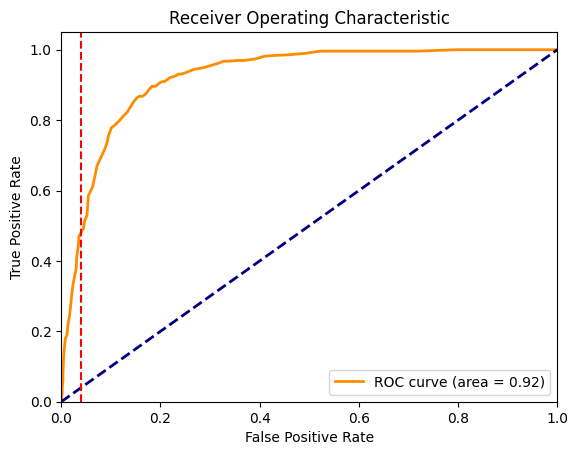

Completed 5-fold CV. Score = 0.6398819492810702


In [68]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])

labels = pd.read_csv("/kaggle/input/amex-default-prediction/train_labels.csv", index_col="customer_ID")
df_train = pd.merge(df_train, labels, left_index=True, right_index=True)

target_column = 'target'
features = [col for col in df_train.columns if col != target_column]

scores = cv_amex_scores(df_train, pipeline, features, target_column)

In [69]:
# Baseline score
np.mean(scores)

0.6244226646066886

<a id='weak_train'></a>
### Weak Learners - Training

In [70]:
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train[features])

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, df_train[target_column], test_size=0.2, random_state=42
)

#### Light GBM

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1977, number of negative: 5938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 7915, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.249779 -> initscore=-1.099792
[LightGBM] [Info] Start training from score -1.099792


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

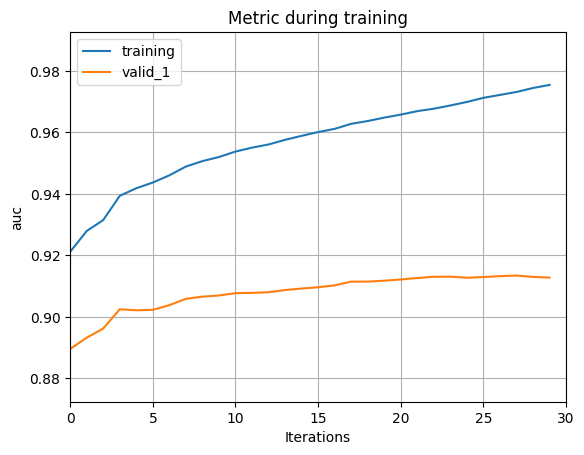

In [71]:
# Train LightGBM
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'num_iterations': 30
}

lgb_train = lgb.Dataset(X_train_split, y_train_split)
lgb_val = lgb.Dataset(X_val_split, y_val_split, reference=lgb_train)

evals={}
lgb_model = lgb.train(params=lgb_params, 
                train_set = lgb_train, 
                valid_sets=[lgb_train, lgb_val],
                callbacks = [lgb.record_evaluation(evals)])

lgb.plot_metric(evals)

#### CatBoost

Learning rate set to 0.194435
0:	test: 0.8441676	best: 0.8441676 (0)	total: 91.3ms	remaining: 4.47s
1:	test: 0.8971241	best: 0.8971241 (1)	total: 110ms	remaining: 2.63s
2:	test: 0.9010816	best: 0.9010816 (2)	total: 128ms	remaining: 2s
3:	test: 0.9008792	best: 0.9010816 (2)	total: 147ms	remaining: 1.69s
4:	test: 0.9006741	best: 0.9010816 (2)	total: 166ms	remaining: 1.49s
5:	test: 0.9006859	best: 0.9010816 (2)	total: 187ms	remaining: 1.37s
6:	test: 0.9015756	best: 0.9015756 (6)	total: 206ms	remaining: 1.27s
7:	test: 0.9037771	best: 0.9037771 (7)	total: 229ms	remaining: 1.2s
8:	test: 0.9048498	best: 0.9048498 (8)	total: 248ms	remaining: 1.13s
9:	test: 0.9059142	best: 0.9059142 (9)	total: 270ms	remaining: 1.08s
10:	test: 0.9069328	best: 0.9069328 (10)	total: 288ms	remaining: 1.02s
11:	test: 0.9083644	best: 0.9083644 (11)	total: 307ms	remaining: 972ms
12:	test: 0.9084795	best: 0.9084795 (12)	total: 326ms	remaining: 928ms
13:	test: 0.9089036	best: 0.9089036 (13)	total: 349ms	remaining: 898ms

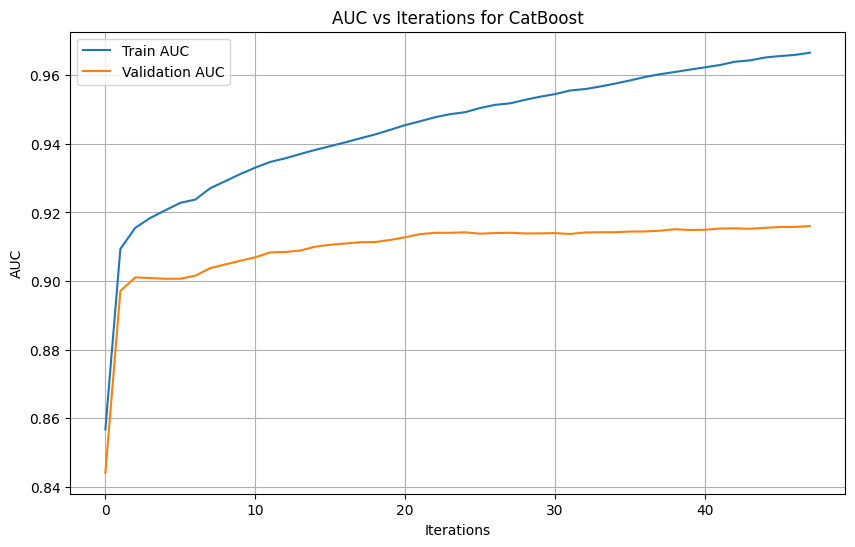

In [72]:
# Train CatBoost
catboost_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 50
}
catboost_model = CatBoostClassifier(**catboost_params)
catboost_model.fit(X_train_split, 
                   y_train_split, 
                   eval_set=(X_val_split, y_val_split), 
                   early_stopping_rounds=10)

# Build pool datasets and get AUC scores over iterations
train_pool = Pool(data=X_train_split, label=y_train_split)
val_pool = Pool(data=X_val_split, label=y_val_split)
auc_train_values = catboost_model.eval_metrics(train_pool, metrics=['AUC'])['AUC']
auc_val_values = catboost_model.eval_metrics(val_pool, metrics=['AUC'])['AUC']

# Get the iteration numbers
iterations = np.arange(len(auc_train_values))

# Plot AUC vs iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, auc_train_values, label='Train AUC')
plt.plot(iterations, auc_val_values, label='Validation AUC')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.title('AUC vs Iterations for CatBoost')
plt.show()

#### XGBoost

[0]	validation_0-auc:0.93039	validation_1-auc:0.89287
[1]	validation_0-auc:0.94472	validation_1-auc:0.89698
[2]	validation_0-auc:0.95321	validation_1-auc:0.90074
[3]	validation_0-auc:0.95806	validation_1-auc:0.90200
[4]	validation_0-auc:0.96304	validation_1-auc:0.90434
[5]	validation_0-auc:0.96601	validation_1-auc:0.90458
[6]	validation_0-auc:0.97089	validation_1-auc:0.90673
[7]	validation_0-auc:0.97371	validation_1-auc:0.90741
[8]	validation_0-auc:0.97727	validation_1-auc:0.90852
[9]	validation_0-auc:0.97958	validation_1-auc:0.90914
[10]	validation_0-auc:0.98165	validation_1-auc:0.90935
[11]	validation_0-auc:0.98304	validation_1-auc:0.90920
[12]	validation_0-auc:0.98535	validation_1-auc:0.90842
[13]	validation_0-auc:0.98737	validation_1-auc:0.90785
[14]	validation_0-auc:0.98926	validation_1-auc:0.90897
[15]	validation_0-auc:0.99024	validation_1-auc:0.90938
[16]	validation_0-auc:0.99100	validation_1-auc:0.91026
[17]	validation_0-auc:0.99162	validation_1-auc:0.91072
[18]	validation_0-au

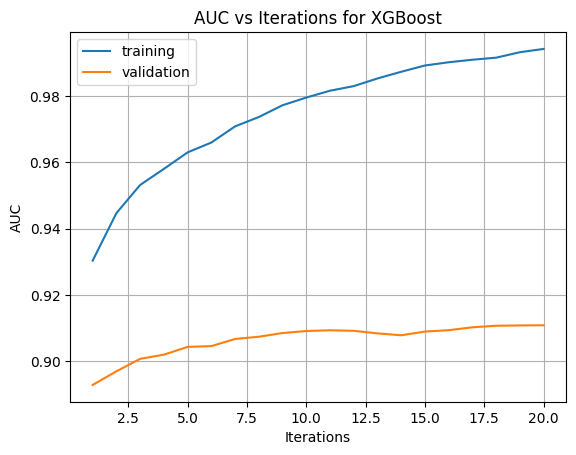

In [73]:
# Train XGBoost
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 20
}

xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train_split, 
          y_train_split, 
          eval_set=[(X_train_split, y_train_split), (X_val_split, y_val_split)])

train_history = xgb_model.evals_result()
iterations = len(train_history["validation_0"]["auc"])

plt.plot(range(1,iterations+1), train_history["validation_0"]["auc"], label="training")
plt.plot(range(1,iterations+1), train_history["validation_1"]["auc"], label="validation")
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.title('AUC vs Iterations for XGBoost')
plt.show()

<a id='weak_pred'></a>
### Weak Learners - Predictions

Now that we have trained our 3 "weak" learners, we can use them to make predictions, that we will use as features for our "strong" learners.

In [74]:
X_test_scaled = scaler.fit_transform(df_test[features])
X_test_scaled.shape

(9967, 100)

In [75]:
lgb_pred_train = lgb_model.predict(X_train_scaled)
lgb_pred_test = lgb_model.predict(X_test_scaled)
catboost_pred_train = catboost_model.predict_proba(X_train_scaled)[:, 1]
catboost_pred_test = catboost_model.predict_proba(X_test_scaled)[:, 1]
xgb_pred_train = xgb_model.predict_proba(X_train_scaled)
xgb_pred_test = xgb_model.predict_proba(X_test_scaled)

predictions_df_train = pd.DataFrame({
    'lightgbm_pred': lgb_pred_train,
    'catboost_pred': catboost_pred_train,
    'xgboost_pred': [x[1] for x in xgb_pred_train],
    'target': df_train[target_column]
})
predictions_df_test = pd.DataFrame({
    'lightgbm_pred': lgb_pred_test,
    'catboost_pred': catboost_pred_test,
    'xgboost_pred': [x[1] for x in xgb_pred_test]
})

In [76]:
# LGB SCORE (on training set)
pred_df = pd.DataFrame(lgb_pred_train, columns=['prediction'], index=df_train.index)
true_df = pd.DataFrame(df_train[target_column], columns=['target'])

amex_metric(true_df, pred_df)

0.8238058609699399

In [77]:
# CATBOOST SCORE (on training set)
pred_df = pd.DataFrame(catboost_pred_train, columns=['prediction'], index=df_train.index)
true_df = pd.DataFrame(df_train[target_column], columns=['target'])

amex_metric(true_df, pred_df)

0.8065460504906584

In [78]:
# XGBOOST SCORE (on training set)
pred_df = pd.DataFrame(predictions_df_train["xgboost_pred"].values, columns=['prediction'], index=df_train.index)
true_df = pd.DataFrame(df_train[target_column], columns=['target'])

amex_metric(true_df, pred_df)

0.9086513712291421

<a id='strong_train'></a>
### Strong Learners - Training

Let's train our "strong" learners on the features we creating by predicting using the "weak" learners.

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

pred_features = ['lightgbm_pred', 'catboost_pred', 'xgboost_pred']
target_col = "target"

# Train RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(predictions_df_train[pred_features], predictions_df_train[target_col])

# Train LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(predictions_df_train[pred_features], predictions_df_train[target_col])

LogisticRegression()

Let's see what kind of score we can expect by using our cross validation code.

We just need to change it a bit to allow it to have two different models.

In [80]:
def cv_amex_scores(df, model_1, model_2, features, target_column):
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    X = df[features]
    y = df[target_column]

    i = 0
    
    # Perform k-fold cross-validation
    for train_idx, test_idx in kf.split(X, y):
        
        print(f"Run {i+1}-fold CV...")

        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]

        # Train the models
        model_1.fit(X_train, y_train)
        model_2.fit(X_train, y_train)

        # Predict probabilities for the test set
        y_prob = 0.5 * (
            model_1.predict_proba(X_test)[:, 1] + 
            model_2.predict_proba(X_test)[:, 1])
        
        pred_df = pd.DataFrame(y_prob, columns=['prediction'], index=y_test.index)
        true_df = pd.DataFrame(y_test, columns=['target'])

        result_df = pd.merge(pred_df, true_df, left_index=True, right_index=True)
        plot_roc_auc(result_df)
        
        model_score = amex_metric(true_df, pred_df)
        scores.append(model_score)
        
        print(f"Completed {i+1}-fold CV. Score = {model_score}")
        i += 1

    return scores

Run 1-fold CV...


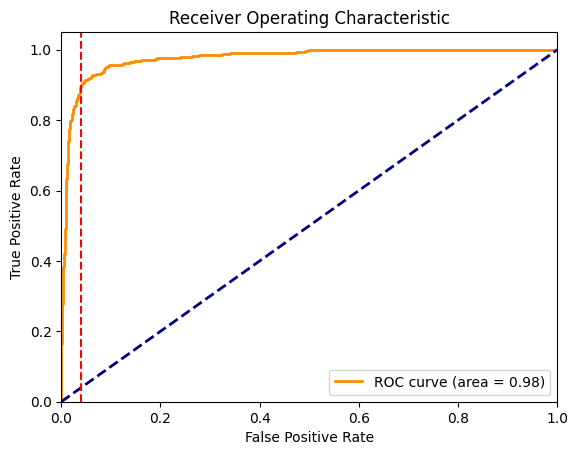

Completed 1-fold CV. Score = 0.8959308095350514
Run 2-fold CV...


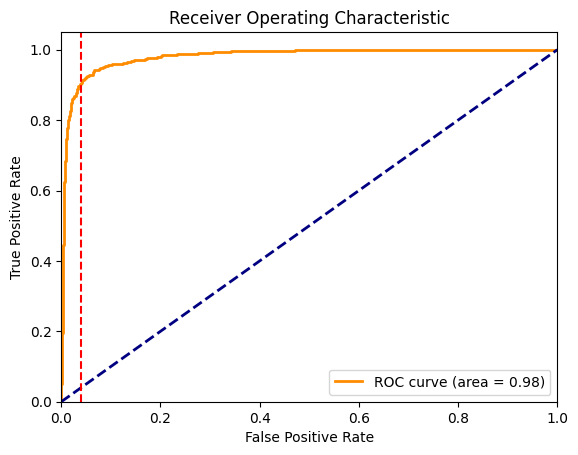

Completed 2-fold CV. Score = 0.9158482086241942
Run 3-fold CV...


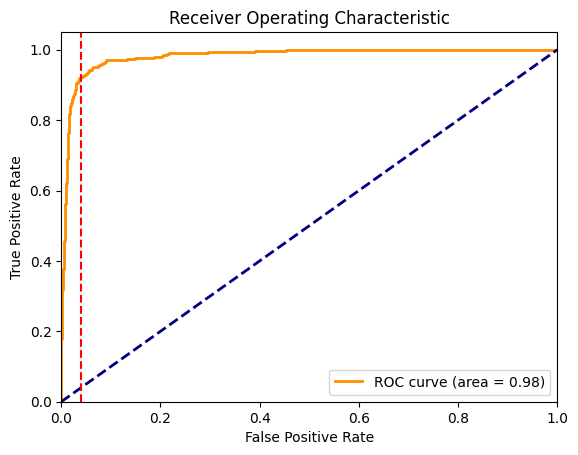

Completed 3-fold CV. Score = 0.918394991384412
Run 4-fold CV...


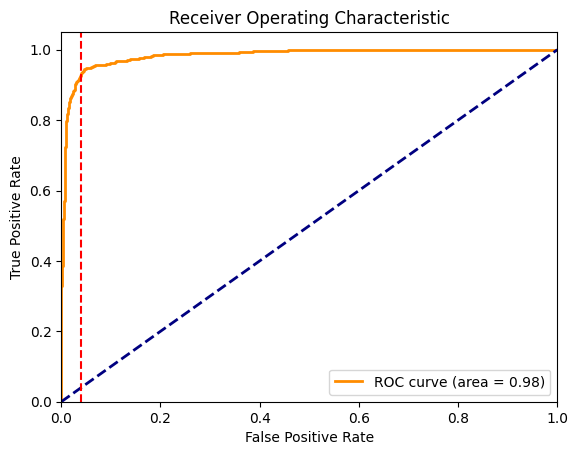

Completed 4-fold CV. Score = 0.9270200975193483
Run 5-fold CV...


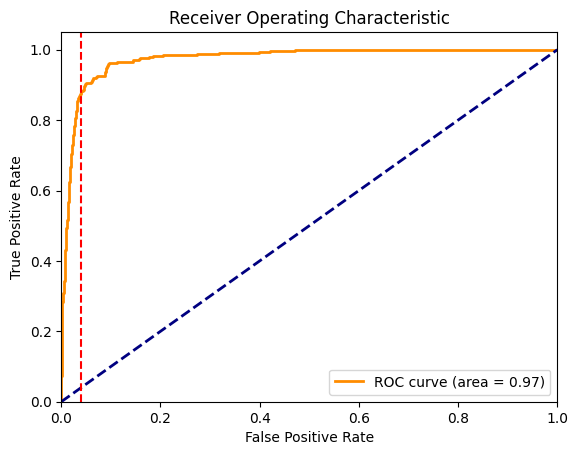

Completed 5-fold CV. Score = 0.8765776225591878


In [81]:
scores = cv_amex_scores(predictions_df_train, RandomForestClassifier(), LogisticRegression(), pred_features, target_col)

In [82]:
# Final score
np.mean(scores)

0.9067543459244387

Our baseline score was about 0.61, so we improved it quite a bit!

But keep in mind that this is just on validation set.

What really counts is the performance on the test set.

<a id='strong_pred'></a>
### Strong Learners - Prediction

We are at the end of our process, we just need to get our predictions on the test set!

We don't have labels for the test set, so the only way to know your score is to submit a .csv file in the AMEX Competition.

In the conclusion section of this notebook, we'll talk about the results we got on the full dataset.

In [83]:
# Predict probabilities using both models
rf_pred_proba = rf_clf.predict_proba(predictions_df_test[pred_features])[:, 1]
lr_pred_proba = lr_clf.predict_proba(predictions_df_test[pred_features])[:, 1]

# Average the predicted probabilities (50% weight each)
ensemble_pred_proba = 0.5 * (rf_pred_proba + lr_pred_proba)

pred_df = pd.DataFrame(ensemble_pred_proba, columns=['prediction'], index=df_test.index)
pred_df.head()

,prediction
customer_ID,
00041d031f2b2c9facd1dda2adb2ddd5bd1f95143a2208912e213302c7d00b6c,0.025895
0004fbbc37e3147810d2d8a8d26b5a18dfb3755dba74c1793bed71bd3e44d9bd,0.006056
00059a7fc495b3bc71df7c4d90800d8ee83377ef8fe4ad12ee6c8ee12057cd1e,0.824433
000b2852a854925d519fed1a6af358e55e9fd7b3e09f797ee8b3ca3b3e7c4f87,0.006252
0011edcc2435b5382ecb9c1b320a65ac84478dccacf29d744db96929e33e6f4d,0.006580


In [84]:
pred_df.shape

(9967, 1)

<a id='conclusion'></a>
## Conclusion
[Back to summary](#summary)

This was project aimed at learning and explain our though process, not at achieving the highest score.

For this reason, we tried to keep things as simple as possible.

And we hope this notebook will be useful for others, looking to learn and improve their skills.

If you liked it, please remember to upvote! Thanks ;)

To let you know our LB score was 0.73667 (Private score) and 0.73565 (Public score).

So far from the 0.80 - 0.81 top scores.

### Next steps for score optimization

If you want to aim for those kind of high scores, starting from this work, here some things you could try:
- We didn't use at all feature S_2, representing date. You could make use of cyclical nature of day of month and month of year by applying a cos and sin transformation
- There are many int features that we used as numeric, even if they have a small number of unique values. Those are probably best used as categorical features, applying one hot encoding
- In the Feature Engineering step, you can try many more aggregations and transformations of the data. You will need to somehow overcome the Kaggle notebook memory limitation though. (Like applying them on chunks of data instead of full data or running the code on a bigger machine on AWS or similar cloud service)
- In the Feature Selection step, you can experiment with different number of features, different estimators for RFE or completely different techniques for selecting features. You can also try to skip the step completely and check the result (keep memory in mind though 😅)
- In the Modeling step, imagination and creativity is your limit. You can experiment with many different models and techniques.
- Also for Modeling, an important step we didn't show here could be hyperparameter-optimization. You can optimize hyper-parameters for each model in order to choose the best ones for the data at hand. For this you can start by having a look at RandomizedSearchCV or GridSearchCV
- Carefully manage bias and variance to avoid overfitting. As you saw we got very high score on the training and validation set, but much lower ones on the test set. This is due to overly complex models that lead to overfitting to the training data.